<center>
<font color='#1DD2AF'>
<h1>Crecimiento de Fracturas y hexaedrización interna</h1>
<h3>Julian Ricardo Salazar Duarte</h3>
<h3> Profesor: Marco Paluszny Kluczynsky</h3>
<h3>Universidad Nacional de Colombia</h3>
<h3>2024-1</h3>
</font>
</center>

### 0. Configuración del entorno

In [1]:
%pip install -r requirements.txt

In [2]:
# Librerias
import numpy as np
from skspatial.objects import Plane, Point, Vector, Line
from skspatial.plotting import plot_3d
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [3]:
inter = None
color_t = None
caras = None
vertex = None
normal = None
M = None
A = None
mp = None
eigenvalues = None
eigenvectors = None
traces = None
tri = None
color_m = None
size = None
max_value = 0
x_axis = None
y_axis = None
squares = None
M_size = None
err = 1e-3

filename = 'FRAC0003_nrIter4.txt'


In [4]:
def new_plot():
    """Crear instancia de una nueva figura en 3d"""
    return go.Figure()

In [5]:
def config_plot(fig, title, x=2):
    """Configura limites de la grafica"""

    global mp, max_value
    
    fig.update_layout(
        title=title,
        scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        xaxis=dict(range=[mp[0]- max_value-x, mp[0] + max_value+x]),
        yaxis=dict(range=[mp[1]- max_value-x, mp[1] + max_value+x]),
        zaxis=dict(range=[mp[2]- max_value-x, mp[2] + max_value+x]),
        )
    )

    return fig

In [6]:
# Carga los datos de la fractura desde un archivo de texto.
dataset = []
with open(filename, 'r') as file:
    for line in file:
        values = [float(value) for value in line.split()]
        dataset.append(values)
M = np.array(dataset)
M_size = M.shape

### 1. Crecimiento de la fractura

El crecimiento de la fractura se refiere al proceso por el cual una fractura, incrustada dentro de un material, se expande en fases sucesivas. A medida que la fractura crece, también lo hacen las cajas contenedoras que la envuelven, lo que trae consigo diversos desafíos geométricos.

El proceso de crecimiento de la fractura comienza con una fractura inicial dentro de una caja contenedora, que está formada por cuadriláteros y rodeada de celdas externas (cubos o hexaedros). Luego, en cada fase de crecimiento, la fractura cambia de forma y tamaño, obligando a recalcular los cuadriláteros de la caja contenedora.

Estos cambios generan un problema: las celdas externas dejan de estar alineadas con los nuevos cuadriláteros de la caja, lo que se traduce en una pérdida de coherencia. Para solucionar esto, se debe ajustar la geometría externa después de cada iteración de crecimiento.

El objetivo de este reajuste es modificar lo menos posible las celdas externas para que la estructura geométrica mantenga su lógica y conectividad. Además, a medida que la fractura sigue creciendo, se generan nuevas cajas contenedoras, y las celdas externas deben adaptarse a estos cambios con la menor modificación posible.

El proceso se repite a lo largo de varias iteraciones, creando una secuencia de cajas y geometrías externas que deben estar en sintonía. El objetivo final es minimizar los costos computacionales al evitar recalcular toda la estructura externa en cada iteración.

In [7]:
print("Primeros 5 puntos")
print(M[:10])

print(M.shape)

Primeros 5 puntos
[[ 9.287534   -0.17168491 -2.04252446]
 [ 9.287534   -0.03942097 -2.12239389]
 [ 9.287534    0.0616885  -2.23922604]
 [ 9.287534    0.1217462  -2.38158456]
 [ 9.287534    0.13487327 -2.5355344 ]
 [ 9.287534    0.09978473 -2.6860059 ]
 [ 9.287534    0.0199153  -2.81826984]
 [ 9.287534   -0.09691685 -2.91937931]
 [ 9.287534   -0.23927537 -2.97943701]
 [ 9.287534   -0.39322522 -2.99256408]]
(80, 3)


In [8]:
fig  = new_plot()

mp = np.mean(M, axis=0)
max_value = np.max(np.abs(M - mp))

# mostrar puntos de la fractura

fig.add_trace(go.Scatter3d(
    x=M[:, 0],
    y=M[:, 1],
    z=M[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color='blue',
    )
))

# Calcular el centro de la fractura

fig = config_plot(fig, 'Fractura')

fig.show()


### 2. Caja contenedora

Hexaedro que encierra la fractura. A medida que la fractura crece, se ajusta el tamaño de la caja contenedora para incluir los nuevos frentes. La caja sirve como una referencia externa para mantener la coherencia con la estructura geométrica que envuelve la fractura.

#### 2.1. Cunstruir caja para un conjunto de puntos en 3D

Tenemos una serie de puntos que representan la fractuta, $M=\{(x,y,z)\}_{i=0}^{i=n}$ y queremos construir una caja contenedora que los envuelva.


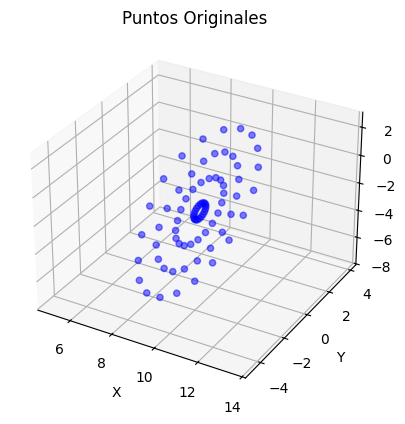

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(M[:, 0], M[:, 1], M[:, 2], color='b', alpha=0.5)
ax.set_title('Puntos Originales')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Puntos Originales')
plt.xlim(mp[0] - max_value, mp[0] + max_value)
plt.ylim(mp[1] - max_value, mp[1] + max_value)
plt.show()

I .La media de los puntos $ \mathbf{mp} $ se calcula como:

$$
\mathbf{mp} = \left( \frac{1}{n} \sum_{i=1}^{n} x_i, \frac{1}{n} \sum_{i=1}^{n} y_i, \frac{1}{n} \sum_{i=1}^{n} z_i \right)
$$


In [10]:
mp = np.mean(M, axis=0)

print(f"Media de los puntos: {mp}")

Media de los puntos: [ 9.28626157 -0.35791399 -2.50120236]


II. Centramos los datos tomando como referencia el punto medio de los datos.

$$
P =  M - \text{Media}
$$

In [11]:
points = M - mp

III. Obtenemos la matriz de covarianza $A$

$$
A = \begin{pmatrix} 
\text{Cov}(x, x) & \text{Cov}(x, y) & \text{Cov}(x, z) \\ 
\text{Cov}(y, x) & \text{Cov}(y, y) & \text{Cov}(y, z) \\ 
\text{Cov}(z, x) & \text{Cov}(z, y) & \text{Cov}(z, z) 
\end{pmatrix}
$$

In [12]:
A = np.cov(points, rowvar=False)

IV. Luego, calculamos los autovectores $ V $ y los autovalores $ \Lambda $ de la matriz de covarianza $ \Sigma $:
   $
   \Sigma V = V \Lambda
   $
   donde:
   - $ V $ es la matriz cuyas columnas son los autovectores.
   - $ \Lambda $ es la matriz diagonal con los autovalores en la diagonal.

**los autovectores** representan las direcciones principales de variación en los datos. Cada autovector indica una dirección en el espacio de características.

**Los autovalores** indican la magnitud de la varianza que se encuentra en las direcciones correspondientes a los autovectores.

In [13]:
eigenvalues, eigenvectors = np.linalg.eig(A)

print(f"Autovectores:\n {eigenvectors}")

print(f"\nAutovalores: {eigenvalues}")

Autovectores:
 [[ 9.99975088e-01 -6.42532701e-03 -2.92212074e-03]
 [-7.05826663e-03 -9.14151277e-01 -4.05311761e-01]
 [ 6.69997997e-05 -4.05322288e-01  9.14173855e-01]]

Autovalores: [2.39527389e-03 5.00117967e+00 4.99941890e+00]


V. Proyectar los puntos centrados en las direcciones de los autovectores. Esto se hace con el producto punto:
   $$
   \mathbf{P}_{\text{transformada}} = \mathbf{P} V
   $$
   donde:
   - $ \mathbf{P} $ es la matriz de puntos centrados (de tamaño $ n \times 3 $).
   - $ V $ es la matriz de autovectores (de tamaño $ 3 \times 3 $).
   - El resultado $ \mathbf{P}_{\text{transformada}} $ es una nueva matriz de puntos proyectados en las direcciones de máxima varianza (autovectores)

In [14]:
points_t = np.dot(points, eigenvectors)

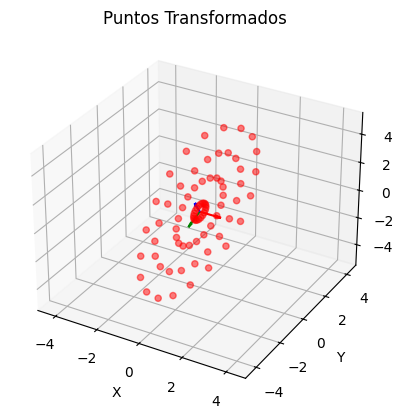

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_t[:, 0], points_t[:, 1], points_t[:, 2], color='r', alpha=0.5)
origin = np.zeros((3, 3))  # Origen de los vectores
ax.quiver(origin[:, 0], origin[:, 1], origin[:, 2], 
          eigenvectors[0, :], eigenvectors[1, :], eigenvectors[2, :], 
          color=['r', 'g', 'b'])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Puntos Transformados')
plt.xlim(-max_value, max_value)
plt.ylim(-max_value, max_value)
plt.show()

VI. Crear puntos de los límites de la caja en el sistema transformado

Si los límites mínimos y máximos son:

$$
\text{min\_limits} = [x_{\text{min}}, y_{\text{min}}, z_{\text{min}}]
$$
$$
\text{max\_limits} = [x_{\text{max}}, y_{\text{max}}, z_{\text{max}}]
$$

Los vértices de la caja se pueden representar como todas las combinaciones de los extremos:

$$
\text{vertex} = \begin{bmatrix}
x_{\text{min}} & y_{\text{min}} & z_{\text{min}} \\
x_{\text{max}} & y_{\text{min}} & z_{\text{min}} \\
x_{\text{min}} & y_{\text{max}} & z_{\text{min}} \\
x_{\text{max}} & y_{\text{max}} & z_{\text{min}} \\
x_{\text{min}} & y_{\text{min}} & z_{\text{max}} \\
x_{\text{max}} & y_{\text{min}} & z_{\text{max}} \\
x_{\text{min}} & y_{\text{max}} & z_{\text{max}} \\
x_{\text{max}} & y_{\text{max}} & z_{\text{max}}
\end{bmatrix}
$$


In [16]:
# Calcula los límites de la caja en el nuevo sistema de coordenadas
min_limits = np.min(points, axis=0) - err
max_limits = np.max(points, axis=0) + err

# Crear puntos de los límites de la caja en el sistema transformado
vertex_t = np.array(np.meshgrid([min_limits[0], max_limits[0]], [min_limits[1], max_limits[1]],
                                    [min_limits[2], max_limits[2]])).T.reshape(-1, 3)

In [17]:
print(f"Vertices de la caja en el sistema transformado:\n {vertex_t}")

Vertices de la caja en el sistema transformado:
 [[-0.16966904 -4.86725041 -4.86894679]
 [-0.16966904  4.86207371 -4.86894679]
 [ 0.15091477 -4.86725041 -4.86894679]
 [ 0.15091477  4.86207371 -4.86894679]
 [-0.16966904 -4.86725041  4.85594723]
 [-0.16966904  4.86207371  4.85594723]
 [ 0.15091477 -4.86725041  4.85594723]
 [ 0.15091477  4.86207371  4.85594723]]


Transformar los vértices de la caja de vuelta al sistema original: esto se hace con el producto punto de los vertices con la transpuesta de los autovectores y sumando la media de los datos:

$$
\text{vertex}_{\text{original}} = \text{vertex} \cdot V^T + \mathbf{mp}
$$

Al multiplicar los vértices por $\cdot V^T $, estamos transformando las coordenadas desde el sistema de coordenadas transformado de vuelta al sistema de coordenadas original.

 Sumar la media al resultado de la multiplicación ajusta la posición de los vértices para que se alineen correctamente en el espacio original.


In [18]:
vertex = np.dot(vertex_t, eigenvectors.T) + mp

print(f"Vertices de la caja en el sistema original:\n {vertex}")

Vertices de la caja en el sistema original:
 [[ 9.16209808  6.06612815 -4.97947252]
 [ 9.09958399 -2.82794592 -8.92298444]
 [ 9.48267391  6.06386538 -4.97945104]
 [ 9.42015982 -2.83020869 -8.92296296]
 [ 9.13368077  2.12451423  3.91077134]
 [ 9.07116668 -6.76955984 -0.03274057]
 [ 9.45425659  2.12225146  3.91079282]
 [ 9.3917425  -6.77182261 -0.03271909]]


In [19]:
def build_box(fig):

    global vertex

    lines = [
        [0, 1], [0, 2], [0, 4],
        [1, 3], [1, 5], [2, 3],
        [2, 6], [3, 7], [4, 5],
        [4, 6], [5, 7], [6, 7]
    ]
    for line in lines:
        fig.add_trace(go.Scatter3d(
            x=[vertex[line[0], 0], vertex[line[1], 0]],
            y=[vertex[line[0], 1], vertex[line[1], 1]],
            z=[vertex[line[0], 2], vertex[line[1], 2]],
            mode='lines',
            line=dict(color='black', width=2)
            )
        )
    return fig

In [20]:
size = int(M_size[0] / 20)
color_m = np.empty((0, 3))

for _ in range(size):
    color = np.random.rand(1, 3)
    color_m = np.concatenate((color_m, np.full((20, 3), color)))

In [21]:
fig = new_plot()

fig = build_box(fig)

fig.add_trace(go.Scatter3d(
    x=M[:, 0],
    y=M[:, 1],
    z=M[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=color_m,
    )
))

# Calcular el centro de la fractura

fig = config_plot(fig, 'Caja contenedora')

fig.show()


### 2. Triangularización y sus normales

la triangulación de los puntos se realizó teniendo en cuenta que cada 20 puntos se genera una nueva iteración que hace que la fractura aumente. por lo que se pueden realizar triangulaciones tomando parejas de puntos consecutivos de la interacion actual y la siguiente.


In [22]:
"""
    Realizar la triangulación de los puntos, teniento en cuenta que cada 20 puntos se apueden realizar
    triangulaiones con los siguientes 20 puntos.

    la variable tri alamacena la dirección de los puntos que forman un triangulo
"""
def triangularization():

    global color_t, tri
    color_t = []
    tri = []
    for i in range(0, size - 1):
        for j in range(20):
            if j == 19:
                tri.append([j + (20 * i), j + (20 * (i + 1)), 0 + (20 * (i + 1))])
                tri.append([j + (20 * i), 0 + (20 * (i + 1)), 0 + (20 * i)])
            else:
                tri.append([j + (20 * i), j + (20 * (i + 1)), (j + 1) + (20 * (i + 1))])
                tri.append([j + (20 * i), (j + 1) + (20 * (i + 1)), (j + 1) + (20 * i)])

            color = (color_m[i] + 2 * color_m[i + 1]) / 3
            color_t.append(color)
            color = (2 * color_m[i] + color_m[i + 1]) / 3
            color_t.append(color)
    color_t = np.array(color_t)
    tri = np.array(tri)

triangularization()

In [23]:
"""
    graficar triangularizacion
"""
def plot_triangles(fig):
       global tri, M, color_t
       for s in range(tri.shape[0]):
            triangle = np.array([M[tri[s][0]], M[tri[s][1]], M[tri[s][2]], M[tri[s][0]]])
            fig.add_trace(go.Scatter3d(
                x=triangle[:, 0],
                y=triangle[:, 1],
                z=triangle[:, 2],
                mode='lines',
                line=dict(color=color_t[s])
            ))

In [24]:
fig = new_plot()
fig = build_box(fig)
plot_triangles(fig)
fig = config_plot(fig, 'Triangulación')
fig.show()

Para obtener las normales de los triangulos se utilizó el producto cruz entre los vectores que se forman con los lados de los triangulos.

Puede ocurrir que hayan triangulos degenerados, es decir, triangulos que sus puntos son colineales, para evitar esto se tiene en cuenta la relación de los dos triangulos anteriores usando el producto cruz, lo que mantiene la coherencia en la dirección del vector normal.

In [25]:
"""
sacar la norma de cada triangulo
"""
isdegenerate = []
def norm():
    global normal
    normal = np.zeros(((size - 1)*40, 3))
    aux = 1
    i = 0
    for triangle in tri:
        p1, p2, p3 = M[triangle]
        v1 = p2 - p1
        v2 = p3 - p1
        n = np.cross(v1, v2)
        normal[i] = n / np.linalg.norm(n)

        if np.isnan(normal[i]).any():
            isdegenerate.append(i)
            
            random_vector = np.random.rand(3)

            random_vector /= np.linalg.norm(random_vector)

            normal[i] = aux * normal[i - 1] / np.abs(np.dot(random_vector, normal[i - 1]))

            normal[i] /= np.linalg.norm(normal[i])

        if i > 0:
            aux = np.dot(normal[i], normal[i - 1])
        i += 1
    normal = np.array(normal)

norm()

In [26]:
"""
graficar la norma de los triangulos
"""
def plot_normals(fig):

    global normal, M, tri

    for i in range(normal.shape[0]):
        mp = np.mean(M[tri[i]], axis=0)
        v = normal[i]
        fig.add_trace(go.Scatter3d(
            x=[mp[0], mp[0] + v[0]],
            y=[mp[1], mp[1] + v[1]],
            z=[mp[2], mp[2] + v[2]],
            mode='lines+markers',
            line=dict(color='blue', width=1),
            marker=dict(size=1, color='blue')
        ))

In [27]:
fig = new_plot()
fig = build_box(fig)
plot_triangles(fig)
plot_normals(fig)
fig = config_plot(fig, 'Normales')
fig.show()

### 3. Interseccion normales en las caras de la caja

Cada cara de la caja puede contener varios triángulos correspondientes a las intersecciones de las normales de los triángulos de la fractura con las caras de la caja. Identificar y organizar estos triángulos en las distintas caras te permitirá modelar cómo la fractura interactúa con la caja. Estos triángulos sirven la base para la construcción de hexaedros en el siguiente paso.

#### 3.1 Promediar vectores normales

La normal de un vertice será promedio de las normales de los triangulos a los que pertenece. 

In [28]:
normal_vertex = None

def get_normal_vertex():
    global normal_vertex, normal, M, tri
    normal_vertex = [[] for _ in range(M.shape[0])]
    for i, n in enumerate(normal):
        for j in tri[i]:
            normal_vertex[j].append(n)

    for i in range(len(normal_vertex)):
        normal_vertex[i] = np.mean(normal_vertex[i], axis=0)

    normal_vertex = np.array(normal_vertex)

get_normal_vertex()



In [29]:
def plot_normals_vertex(fig):

    global normal_vertex, M

    for i in range(normal_vertex.shape[0]):
        fig.add_trace(go.Scatter3d(
            x=[M[i, 0], M[i, 0] + normal_vertex[i, 0]],
            y=[M[i, 1], M[i, 1] + normal_vertex[i, 1]],
            z=[M[i, 2], M[i, 2] + normal_vertex[i, 2]],
            mode='lines+markers',
            line=dict(color='blue', width=1),
            marker=dict(size=1, color='blue')
        ))

In [30]:
fig = new_plot()
fig = build_box(fig)
plot_triangles(fig)
plot_normals_vertex(fig)
fig = config_plot(fig, 'Normales en los vertices')
fig.show()

#### 3.2. Interseccion normales del triangulo con las caras de la caja

I. Para cada vertice se crea una linea que parte del vertice $mp$ en la dirección de la normal $v$ correspondiente al vertice.

Dado un punto de inicio $ \mathbf{mp} $ y un vector director $ \mathbf{v} $, la ecuación de la línea en forma paramétrica es:

$$
\mathbf{L}(t) = \mathbf{mp} + t \cdot \mathbf{v}
$$

Donde:
- $ \mathbf{L}(t) $ es el punto en la línea en función del parámetro $ t $,
- $ \mathbf{mp} $ es el punto de inicio de la línea,
- $ \mathbf{v} $ es el vector director de la línea,
- $ t $ es un parámetro escalar que varía en los números reales ($ t \in \mathbb{R} $).



II. Intersectar línea con las caras de la caja.

Dada una línea paramétrica $ \mathbf{L}(t) = \mathbf{p_0} + t \cdot \mathbf{v} $ y un plano definido por la ecuación $ \mathbf{n} \cdot (\mathbf{p} - \mathbf{p_{\text{plane}}}) = 0 $, donde:

- $ \mathbf{p_0} $ es un punto en la línea,
- $ \mathbf{v} $ es el vector director de la línea,
- $ \mathbf{n} $ es el vector normal al plano,
- $ \mathbf{p_{\text{plane}}} $ es un punto en el plano,
- $ t $ es el parámetro escalar de la línea.

La ecuación para encontrar el parámetro $ t $ en la intersección es:

$$
t = \frac{\mathbf{n} \cdot (\mathbf{p_{\text{plane}}} - \mathbf{p_0})}{\mathbf{n} \cdot \mathbf{v}}
$$

Donde:
- Si $ \mathbf{n} \cdot \mathbf{v} = 0 $, la línea es paralela al plano y no hay intersección (o está contenido en el plano),
- Si $ t $ es una solución real, puedes sustituir este valor en $ \mathbf{L}(t) $ para obtener el punto de intersección.

### Punto de Intersección
El punto de intersección $ \mathbf{p_{\text{inter}}} $ es:

$$
\mathbf{p_{\text{inter}}} = \mathbf{p_0} + t \cdot \mathbf{v}
$$


III. Se verifican las intersecciones que están en la dirección correcta (en la misma dirección que la normal) haciendo uso del producto punto. Si la intersección cumple con esta condición, se agrega a la lista de intersecciones.

IV. De todas las intersecciones válidas, se selecciona la más cercana al vértice.

In [31]:
caras = []
points = np.array(
    [[0, 1, 2, 3],
    [0, 1, 4, 5],
    [0, 4, 2, 6],
    [7, 5, 3, 1],
    [7, 6, 3, 2],
    [7, 6, 5, 4]]
    )

def plane_from_points():
    """
        Calcula los planos a partir de puntos dados y los guarda en la lista.
    """
    for p in points:
        p1, p2, p3 = vertex[p[0]], vertex[p[1]], vertex[p[2]]
        caras.append(Plane.from_points(p1,p2,p3))

plane_from_points()

In [32]:
"""
    Crea una línea a partir de un punto y un vector.

    Args:
    - point: Punto inicial de la línea.
    - vector: Vector director de la línea.

    Returns:
    - Líne
"""
def make_line(point, vector):
    return Line(point=point, direction=vector)

In [33]:
"""
Verifica si un punto final está en la dirección de un vector dado desde un punto inicial.
"""
def is_direction(pi, pf, vd):
    vr = pf - pi
    return np.dot(vr, vd) > 0


In [34]:
"""
Encuentra la intersección más cercana a un punto inicial desde una lista de intersecciones.
"""
def close_intersection(pi, intersections):
    intersect = None
    min_dist = float('inf')
    point = Point(pi)
    for intersection in intersections:
        dist = point.distance_point(intersection)
        if dist < min_dist:
            min_dist = dist
            intersect = intersection
            
    return intersect

In [35]:
"""
Encuentra la intersección más cercana de una línea con varias caras (planos).
"""
def intersection_plane_line(line, pi, vd):
    intersections = []
    for i, plane in enumerate(caras):
        point = plane.intersect_line(line)
        if point is not None and is_direction(pi, point, vd):
            intersections.append(point)

    return close_intersection(pi, intersections)


In [36]:
"""
Calcula las intersecciones más cercanas de líneas definidas por puntos medios de triángulos y sus normales con las caras de la caja.

Utiliza las normales de los triángulos y los puntos medios de los triángulos para definir las líneas.
Luego, encuentra la intersección más cercana de cada línea con las caras de la caja.
Las intersecciones se almacenan en una variable global `inter`.
"""
def intersection():
    global inter  
    inter = [] 
    
    for i in range(normal_vertex.shape[0]):
        mp = M[i] # np.mean(M[tri[i]], axis=0)
        v = normal_vertex[i]
        if np.any(np.isnan(normal_vertex[i])):
            inter.append(normal_vertex[i])
            continue
        line = make_line(mp, v)
        r = intersection_plane_line(line, mp, v)
        inter.append(r)
    inter = np.array(inter)


intersection()

In [37]:
def plot_intersections(fig):
    global inter, size, color_m
    fig.add_trace(go.Scatter3d(
        x=inter[:, 0],
        y=inter[:, 1],
        z=inter[:, 2],
        mode='markers',
        marker=dict(
            color=color_m,
            size=2
        )
    ))

In [38]:
fig = new_plot()
fig = build_box(fig)
plot_intersections(fig)
fig = config_plot(fig, 'Intersecciones')
fig.show()

#### 3.3 Triangularización en la superficie de la caja

Como la tringularización de la superficie de la caja es similar a la triangularización de la fractura, y la tringularización de la fractura ya se ha realizado, se puede usar la misma variable (*tri*) que almacena las posiciones de los triangulos de la fractura interna.

In [39]:
def plot_surface_triangles(fig):
    global inter, tri, color_t

    for s in range(len(tri)):
        triangle = np.array([inter[tri[s][0]], inter[tri[s][1]], inter[tri[s][2]], inter[tri[s][0]]])
        fig.add_trace(go.Scatter3d(
            x=triangle[:, 0],
            y=triangle[:, 1],
            z=triangle[:, 2],
            mode='lines',
            line=dict(color=color_t[s])
        ))



In [40]:
fig = new_plot()
fig = build_box(fig)
plot_surface_triangles(fig)
fig = config_plot(fig, 'Tringularización en Superficie')
fig.show()